# CO2 Analysis

We will be exploring relationships of various metrics (weather, time and date) and the CO2 measurement in an apartment. 

In [ ]:
# Importing relevant Python packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
import matplotlib.pyplot as plt 


## 1. Importing datasets

### 1.1. Importing a dataset with daily outside weather

In [ ]:
# Importing data with outside weather - the dataset is hosted on GitHub
url =  'https://raw.githubusercontent.com/olga-terekhova/weather-co2/main/data/weatherstats_toronto_daily.csv'

# Reading into a Pandas dataframe
df_outside = pd.read_csv(url, sep = ",")

# Printing first several rows of the dataset:
print(df_outside.head())

# Printing the number of rows and columns and the list of columns
print('Dataset shape: ',df_outside.shape)
print(df_outside.columns)


         date  max_temperature  avg_hourly_temperature  avg_temperature  \
0  2022-04-11             12.5                    6.43             7.00   
1  2022-04-10              9.4                    4.10             5.00   
2  2022-04-09              7.8                    3.98             4.45   
3  2022-04-08              9.7                    5.98             6.10   
4  2022-04-07             13.8                    9.00             9.40   

   min_temperature  max_humidex  min_windchill  max_relative_humidity  \
0              1.5          NaN            NaN                     91   
1              0.6          NaN            NaN                     78   
2              1.1          NaN            NaN                     93   
3              2.5          NaN            NaN                    100   
4              5.0          NaN            NaN                    100   

   avg_hourly_relative_humidity  avg_relative_humidity  ...  \
0                          66.8                

This dataset has data on weather in Toronto during last 1000 days aggregated to daily measurements. 

#### 1.1.1. Preprocessing the dataset with the outdoor weather

In [ ]:
# Keeping only possibly relevant columns (daily averages built on hourly measurements)
df_outside = df_outside[['date','avg_hourly_temperature',
         'avg_hourly_relative_humidity','avg_hourly_dew_point', 
         'avg_hourly_wind_speed',
         'avg_hourly_pressure_station',
         'avg_hourly_health_index', 'precipitation']]

# Checking for empty values
print(df_outside.isnull().sum())

# Dropping records with empty values
df_outside = df_outside[df_outside['precipitation'].notnull()]

# Checking for empty values again
df_outside.isnull().sum()

date                            0
avg_hourly_temperature          0
avg_hourly_relative_humidity    0
avg_hourly_dew_point            0
avg_hourly_wind_speed           0
avg_hourly_pressure_station     0
avg_hourly_health_index         0
precipitation                   5
dtype: int64


date                            0
avg_hourly_temperature          0
avg_hourly_relative_humidity    0
avg_hourly_dew_point            0
avg_hourly_wind_speed           0
avg_hourly_pressure_station     0
avg_hourly_health_index         0
precipitation                   0
dtype: int64

There were several rows with empty values for precipitation. We can drop them as there are very few of them compared to the whole size of the dataset.

### 1.2. Importing a dataset with indoor measurements

In [ ]:
# Importing data with indoor metrics - the dataset is hosted on GitHub

url = 'https://raw.githubusercontent.com/olga-terekhova/weather-co2/main/data/indoor_stats_hourly.csv'
df_inside = pd.read_csv(url, sep = ",")

# Printing first several rows of the dataset
print(df_inside.head())

# Printing the number of rows and columns and the list of columns
print('Dataset shape: ',df_inside.shape)
print(df_inside.columns)

   Unnamed: 0        date  hour  avg_indoor_co2  avg_indoor_temp  \
0           0  2021-03-15     5      675.491588        26.064010   
1           1  2021-03-15     6      689.492172        25.976376   
2           2  2021-03-15     7      690.564899        25.787121   
3           3  2021-03-15     8      658.301389        25.615745   
4           4  2021-03-15     9      639.362121        25.502324   

   avg_indoor_humidity  
0            34.457867  
1            35.568939  
2            34.767500  
3            33.327210  
4            32.409646  
Dataset shape:  (9252, 6)
Index(['Unnamed: 0', 'date', 'hour', 'avg_indoor_co2', 'avg_indoor_temp',
       'avg_indoor_humidity'],
      dtype='object')


This dataset has a log of measurements for CO2, humidity and temperature in an apartment in Toronto for a range of days between March 2021 and April 2022. The dataset is aggregated to hourly measurements and has 9252 rows in total. 

#### 1.2.1. Preprocessing the dataset with indoor measurements

In [ ]:
# Checking for empty values
print(df_inside.isnull().sum())

# Renaming some columns
df_inside = df_inside.rename(columns={"Date":"date","avg_indoor_temp":"avg_indoor_temperature"})

# Creating a column 'month' derived from date
df_inside = df_inside.assign(month=lambda x: x.date.str.slice(5, 7).astype(int)) 

# Creating a column 'dayofweek' derived from date (0 - Monday, ..., 6 - Sunday)
df_inside = df_inside.assign(dayofweek=lambda x: pd.to_datetime(x.date).dt.dayofweek) 

# Printing several first rows of the enriched dataset
df_inside.head()



Unnamed: 0             0
date                   0
hour                   0
avg_indoor_co2         0
avg_indoor_temp        0
avg_indoor_humidity    0
dtype: int64


,Unnamed: 0,date,hour,avg_indoor_co2,avg_indoor_temperature,avg_indoor_humidity,month,dayofweek
0,0,2021-03-15,5,675.491588,26.064010,34.457867,3,0
1,1,2021-03-15,6,689.492172,25.976376,35.568939,3,0
2,2,2021-03-15,7,690.564899,25.787121,34.767500,3,0
3,3,2021-03-15,8,658.301389,25.615745,33.327210,3,0
4,4,2021-03-15,9,639.362121,25.502324,32.409646,3,0


No empty values in this dataset.

### 1.3. Merging two source datasets into one single dataset

In [ ]:
# Merging two datasets together using the common attribute 'data'. 
# That leaves only rows with the same range of dates.

df_result = pd.merge(df_inside,df_outside,on = ['date'])

# Printing first 10 rows of the resulting dataset
print(df_result.head(10))

# Printing the number of rows and columns and the list of columns
print('Dataset shape: ',df_result.shape)
print(df_result.columns)

   Unnamed: 0        date  hour  avg_indoor_co2  avg_indoor_temperature  \
0           0  2021-03-15     5      675.491588               26.064010   
1           1  2021-03-15     6      689.492172               25.976376   
2           2  2021-03-15     7      690.564899               25.787121   
3           3  2021-03-15     8      658.301389               25.615745   
4           4  2021-03-15     9      639.362121               25.502324   
5           5  2021-03-15    10      618.087500               25.455833   
6           6  2021-03-15    11      605.772601               25.782472   
7           7  2021-03-15    12      605.279526               26.071247   
8           8  2021-03-15    13      578.753056               26.394676   
9           9  2021-03-15    14      576.787325               26.653472   

   avg_indoor_humidity  month  dayofweek  avg_hourly_temperature  \
0            34.457867      3          0                   -4.79   
1            35.568939      3         

The merged dataset contains dates that were present in both source datasets. The overall number of rows is 9140. As one of the source dataset was detailed to the date level and the other to the hour level, the final dataset is detailed to the hour level.

## 2. Exploratory data analysis

In [ ]:
# Print out the number of rows and columns in the dataset
print("Dimensionality of the DataFrame:", df_result.shape)

Dimensionality of the DataFrame: (9140, 15)


In [ ]:
# Print out summary statistics for each variable in the dataset
df_result.describe()

,Unnamed: 0,hour,avg_indoor_co2,avg_indoor_temperature,avg_indoor_humidity,month,dayofweek,avg_hourly_temperature,avg_hourly_relative_humidity,avg_hourly_dew_point,avg_hourly_wind_speed,avg_hourly_pressure_station,avg_hourly_health_index,precipitation
count,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000
mean,4603.140481,11.484136,586.375703,26.613744,48.387386,6.278337,2.983589,9.540185,68.952691,3.583928,15.749817,99.508389,2.591422,2.444179
std,2660.835083,6.921904,79.472576,0.868568,13.737207,3.402623,1.987034,10.628786,13.644356,10.481103,6.315768,0.667140,0.632072,6.168528
min,0.000000,0.000000,315.713535,23.309432,24.238851,1.000000,0.000000,-17.550000,29.700000,-26.500000,6.420000,97.330000,1.200000,0.000000
25%,2284.750000,5.000000,532.569842,25.994975,37.093374,3.000000,1.000000,1.350000,61.600000,-3.700000,10.750000,99.120000,2.100000,0.000000
50%,4617.500000,11.000000,584.010480,26.558333,44.622734,6.000000,3.000000,9.000000,68.900000,3.000000,14.460000,99.460000,2.500000,0.000000
75%,6902.250000,17.000000,636.718548,27.166280,61.292298,9.000000,5.000000,19.220000,76.800000,12.900000,19.380000,99.920000,3.000000,1.800000
max,9201.000000,23.000000,1095.733977,32.636571,83.737386,12.000000,6.000000,27.500000,100.000000,21.900000,39.120000,101.500000,4.500000,56.000000


In [ ]:
# Print out the data type of each feature in the dataset
print("Data type of each feature:")
df_result.dtypes

Data type of each feature:


Unnamed: 0                        int64
date                             object
hour                              int64
avg_indoor_co2                  float64
avg_indoor_temperature          float64
avg_indoor_humidity             float64
month                             int64
dayofweek                         int64
avg_hourly_temperature          float64
avg_hourly_relative_humidity    float64
avg_hourly_dew_point            float64
avg_hourly_wind_speed           float64
avg_hourly_pressure_station     float64
avg_hourly_health_index         float64
precipitation                   float64
dtype: object

All variables are numeric which will be convenient for modelling. The variable for 'date', which is not numeric, will not be used in modelling. 

In [ ]:
# Determine if there are any missing datapoints or duplicate rows in the dataset
print("\nAre there any missing datapoints in the dataset?", df_result.isnull().values.any())
print("Number of duplicated rows:", df_result.duplicated().sum())


Are there any missing datapoints in the dataset? False
Number of duplicated rows: 0


No missing datapoints and no duplicates.

### 2.1. Data visualization

#### 2.1.1. Checking for normal distribution

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9872538447380066, 7.4846211722505905e-28)


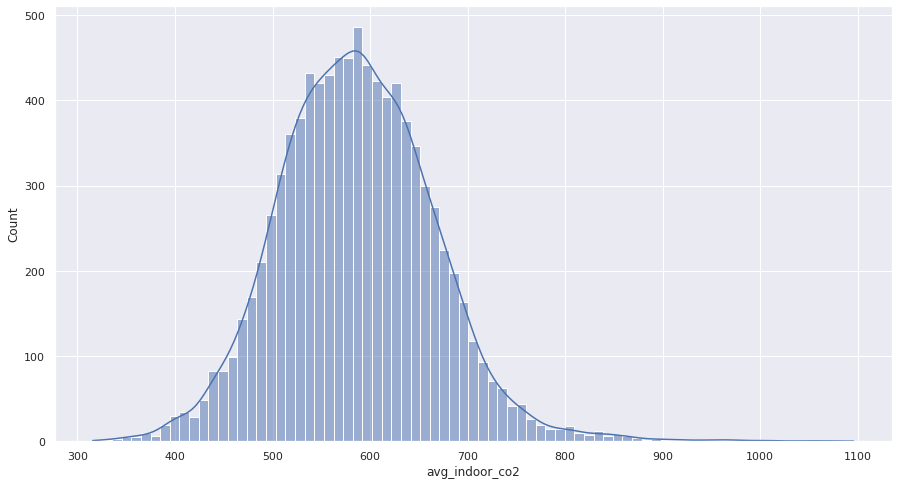

In [ ]:
# Checking the distribution of indoor CO2 (target variable)

sns.histplot(df_result['avg_indoor_co2'], kde=True)
print(stats.shapiro(df_result['avg_indoor_co2']));

Indoor CO2 measurements conform to normal distribution, so no need to transform this variable to satisfy linear regression conditions.

The distribution also shows that current airflow management in this unit is quite good, as the mean is a little bit under 600 and measurements rarely creep up into high numbers.

#### 2.1.2. Checking multicolinearity of independent variables

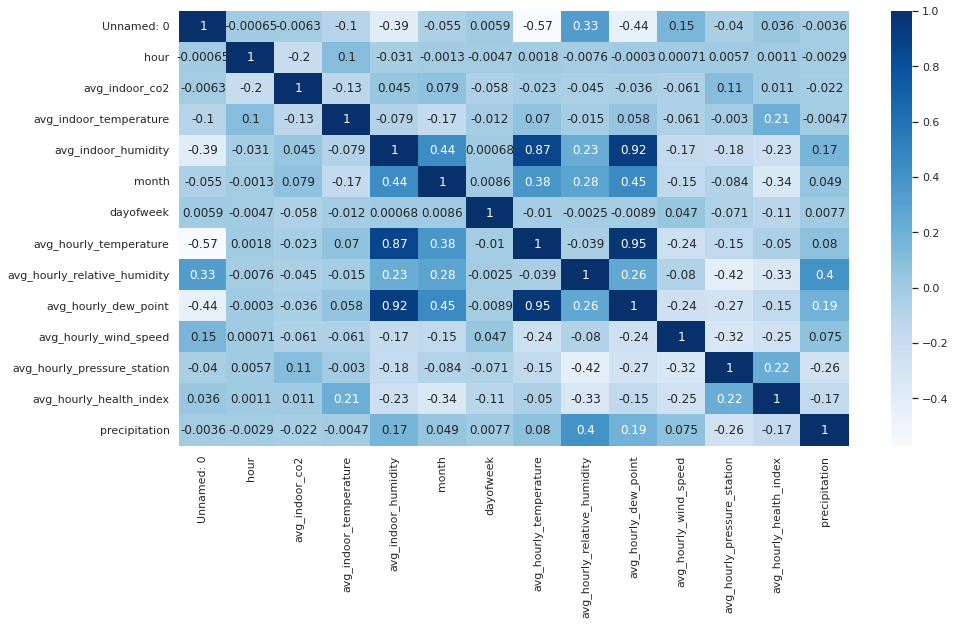

In [ ]:
# Check correlations using plotting a heat map of correlations:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_result.corr(), cmap='Blues', annot=True);

There are several correlated independent variables. 
We'll drop columns 'avg_indoor_humidity', 'precipitation', 'avg_hourly_dew_point' and check for correlations again. 

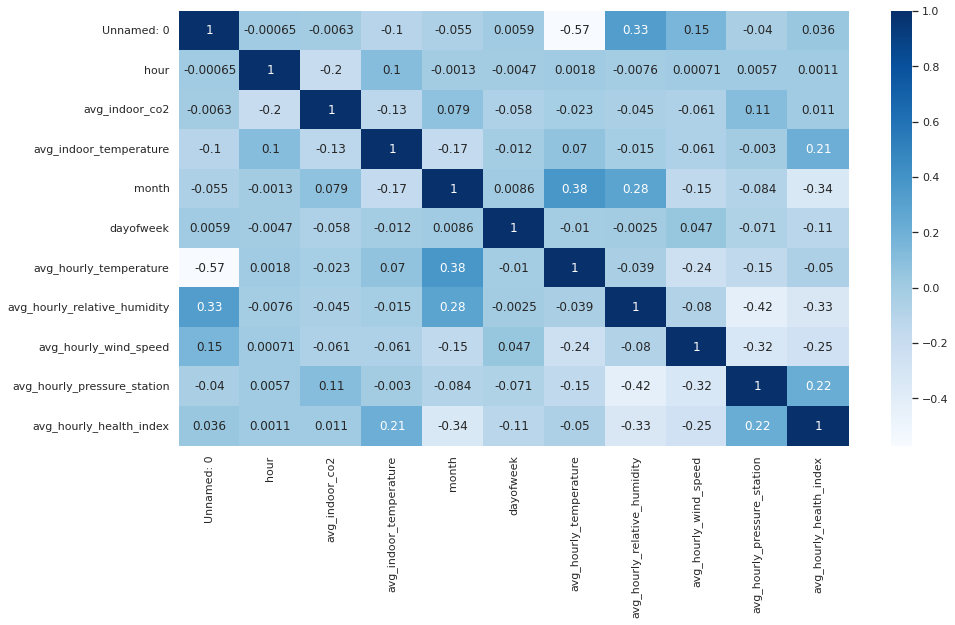

In [ ]:
# Removing  'avg_indoor_humidity', 'precipitation', 'avg_hourly_dew_point'
df_result = df_result.drop(columns=['avg_indoor_humidity','precipitation','avg_hourly_dew_point'])

# Plotting the heatmap again
sns.heatmap(df_result.corr(), cmap='Blues', annot=True);

Now the independent variables are not correlated.
When we check for correlations with the target variable 'avg_indoor_co2', there are not strong correlations either, so we suspect the selected independent variables will not have a lot of explanatory power in the final linear regression model. 

#### 2.1.3. Visualizing independent variables

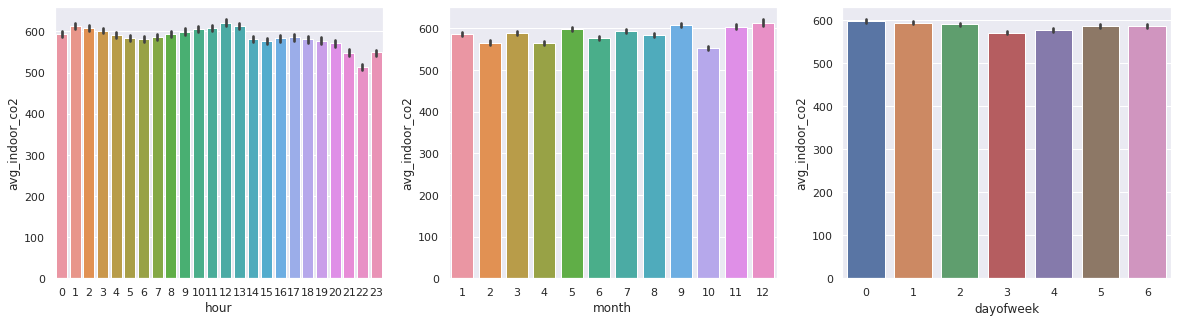

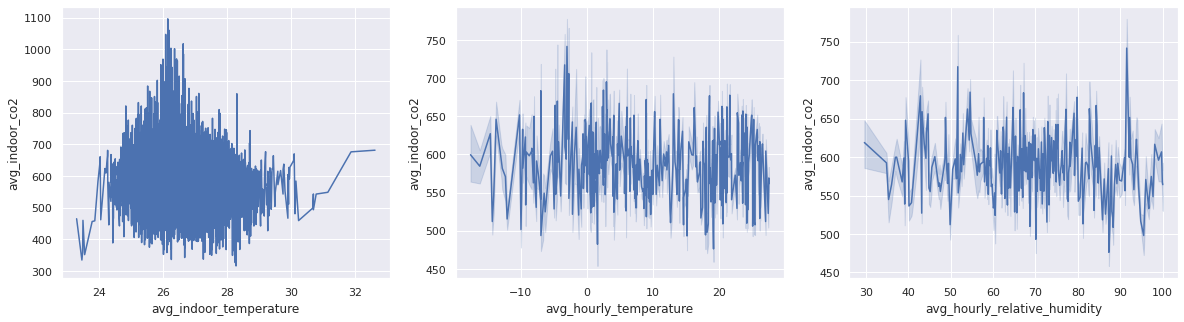

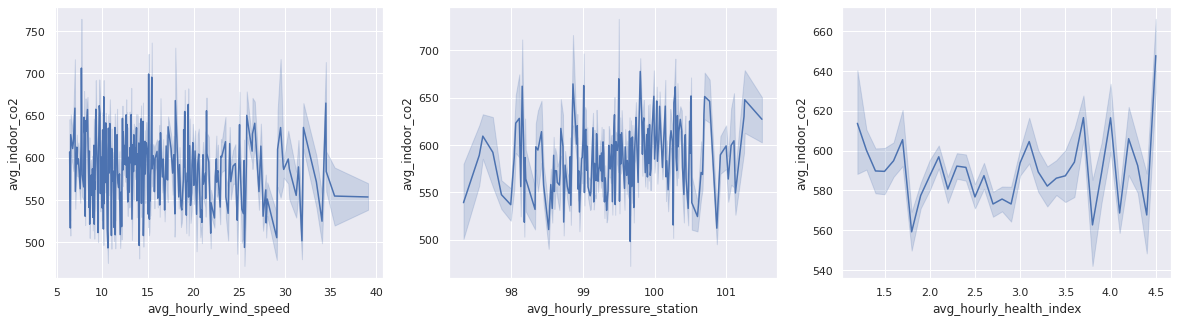

In [ ]:
# Plot the relationship between the independent variables (hour, 
# avg_hourly_pressure_station, avg_indoor_temperature, month, day of week,
# and the dependent/target variable (indoor co2)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.barplot(x='hour', y='avg_indoor_co2', data=df_result, ax=ax0);
sns.barplot(x='month', y='avg_indoor_co2', data=df_result, ax=ax1);
sns.barplot(x='dayofweek', y='avg_indoor_co2', data=df_result, ax=ax2);

fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(20,5))
sns.lineplot(x='avg_indoor_temperature', y='avg_indoor_co2', data=df_result, ax=ax3);
sns.lineplot(x='avg_hourly_temperature', y='avg_indoor_co2', data=df_result, ax=ax4);
sns.lineplot(x='avg_hourly_relative_humidity', y='avg_indoor_co2', data=df_result, ax=ax5);

fig, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(20,5))
sns.lineplot(x='avg_hourly_wind_speed', y='avg_indoor_co2', data=df_result, ax=ax6);
sns.lineplot(x='avg_hourly_pressure_station', y='avg_indoor_co2', data=df_result, ax=ax7);
sns.lineplot(x='avg_hourly_health_index', y='avg_indoor_co2', data=df_result, ax=ax8);

It appears there are some trends for the 3 categorical variables derived from date/time:
- CO2 seems to be lower in the evening - probably due to the fact that inhabitants are often out in the evening, they manage CO2 better when they are not working, and they air the unit before sleep. 
- CO2 seems to be the lowest in October, and highest in September and January. As only around one year of data is observed, this observation is not very reliable. For longer spans it might have been a consequence of heating or cooling in the apartment, as people usually leave smaller cracks in extreme cold or extreme heat. 
- CO2 seems to be the lowest on Thursday and the highest on Monday. This observation is puzzling and there is a need in more hypotheses that could try explaining that. 

It's hard to glean any meaningful insights for the 6 continuous variables, except for the slight correlation between indoor CO2 and air pressure (0.11 according to the heatmap above). 

There is an interesting observation for indoor temperature and CO2. As the thermostat is set at around 23 degrees, the values higher than that might mean that there's a cool pocket at the thermostat and the ventilation in the unit doesn't bring the temperature to the same level. When the measured temperature is close to the target 23 degrees, CO2 is also lower, which might mean that better ventilation in the unit mixes indoor air better, both decreasing CO2 and indoor temperature. It also might mean that when the window crack is open sufficiently, both CO2 and temperature levels drop.

## 3. Preprocessing

As all independent variables and the target variables are already numerical, there's no need for additional encoding.

## 4. Modelling

We'll try following models:
1. Linear regression
2. Decision Tree
3. Random Forest
4. Neural Network
5. Nearest Neighbours

As our target variable is numeric and continuous, we need to use regression versions of those models.

### 4.1. Create train and test datasets

We'll define train and test datasets that we'll use for all models below.

In [ ]:
# Defining X (features) and y (target)

X = df_result[['hour','month','dayofweek','avg_indoor_temperature', 'avg_hourly_temperature', 'avg_hourly_relative_humidity',
               'avg_hourly_wind_speed', 'avg_hourly_pressure_station', 'avg_hourly_health_index']]

y = df_result['avg_indoor_co2']
X.head()

# Spliting the dataset into X_train, X_test, y_train, and y_test
# Retaining 10% of the data for testing, and use a random state value of "0"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

Our datasets have 9 features.

### 4.2. Linear regression

We will build a linear regression model to predict indoor CO2 measurments based on hour, month, day of the week, indoor and outdoor temperature, outdoor humidity, wind speed, pressure and health index.

#### 4.2.1. Build the model

In [ ]:
# Instantiate a linear regression model
linear_model = LinearRegression() 

# Fit the model using the training data
linear_model.fit(X_train, y_train) 

# Print out the intercept and coefficients for the linear regression model
print(linear_model.intercept_)
print(linear_model.coef_)

104.53648637373817
[-2.16967867  2.46971077 -2.0226479  -8.40347034 -0.38531855 -0.31728482
 -0.4919888   7.52656797  1.88798216]


#### 4.2.2. Make predictions

In [ ]:
# For each record in the test set, make a prediction for the y value (transformed value of charges)
# The predicted values are stored in the y_pred array
y_pred = linear_model.predict(X_test)

#### 4.2.3. Model evaluation

In [ ]:
# Metrics

MSE = (1 / len(y_test)) * sum ((y_test - y_pred)**2)
MAE = (1 / len(y_test)) * sum (abs(y_test - y_pred))
RSS = sum ((y_test - y_pred)**2)
TSS = sum ((y_test - y_test.mean())**2)
R_squared = 1 - (RSS/TSS)

print("\n")
print("Mean squared error (MSE) =", MSE)
print("Mean absolute error (MAE) =", MAE)
print("R^2 =", R_squared)

# The metrics package in Python can derive the model evaluation metrics
print("Mean squared error (MSE) =", metrics.mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE) =", metrics.mean_absolute_error(y_test, y_pred))
print("R^2 =", metrics.r2_score(y_test, y_pred))



Mean squared error (MSE) = 6108.852664547078
Mean absolute error (MAE) = 60.59873346368757
R^2 = 0.07732684476711205
Mean squared error (MSE) = 6108.852664547086
Mean absolute error (MAE) = 60.59873346368753
R^2 = 0.07732684476711105


R squared at 7.7% shows that the model has very little predictive power. 

It might mean that outdoor weather doesn't influence the concentration of CO2 much. The factors outside the model, like the number of CO2 producing inhabitants in the unit and the patterns of managing airflow via window cracks and building ventilation might have more weight. It could also mean that the data is not linearly separable. 

### 4.3. Decision Tree

Next we'll try using a single decision tree, hoping for high interpretability of the results.
As we're trying to predict a continuous variable, we need to use a regression decision tree. 

#### 4.3.1 Build the model

In [ ]:
# Importing packages for Decison Tree Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

The function to score the model should be changed from accuracy (suitable for classification tasks) to R squared (suitable for regression tasks).

In [ ]:
# define a function to score a model

def get_acc(model, X, t):
    # 1. Get a vector of predicted results
    y_pred = model.predict(X) # uses tree.predict method

    # 2. Get a vector of actual labels - t

    # 3. acc = R squared
    acc = metrics.r2_score(t, y_pred)
    return acc

In [ ]:
# define a function that selects the best tree model among models with different depths
# selection is based on model score

def select_model(depths,  criterion ):
    out = {}
    for d in depths:
        print('Evaluating on depth {}'.format(d))
        out[d] = {}
        tree = DecisionTreeRegressor(max_depth = d,criterion = criterion) 
        tree.fit(X_train, y_train)  
        out[d]['test'] = get_acc(tree, X_test, y_test) 
        out[d]['train'] = get_acc(tree, X_train, y_train)
        out[d]['model'] = tree
    return out

#### 4.3.2. Make predictions and evaluate models

In [ ]:
depths = [2,5,8,9,10,15,20,30,50,70] # the depths we want to explore go in the depths list   

res_sq_error = select_model(depths, "squared_error") # training models with different depths using squared error as criterion
# looping over the different models and scores to find the optimal model according to its test score
best_d_sq_error = None
best_acc_sq_error = 0

for d in res_sq_error:
    test_acc = res_sq_error[d]['test']
    print("Depth: {}   Train: {}    Test: {}".format(d, res_sq_error[d]['train'], test_acc))
    if test_acc  > best_acc_sq_error:
        best_d_sq_error = d
        best_acc_sq_error = test_acc

print('Best d (sq_error): ' + str(best_d_sq_error))
print('Best accuracy (sq_error): ' + str(best_acc_sq_error))


Evaluating on depth 2
Evaluating on depth 5
Evaluating on depth 8
Evaluating on depth 9
Evaluating on depth 10
Evaluating on depth 15
Evaluating on depth 20
Evaluating on depth 30
Evaluating on depth 50
Evaluating on depth 70
Depth: 2   Train: 0.0814904846255331    Test: 0.07268540404816126
Depth: 5   Train: 0.17545603267445553    Test: 0.12489837179163876
Depth: 8   Train: 0.3583563381479895    Test: 0.21659674946353535
Depth: 9   Train: 0.43102726435495686    Test: 0.25748791156185824
Depth: 10   Train: 0.5021376536520191    Test: 0.28647104379569166
Depth: 15   Train: 0.8360287533287805    Test: 0.4134143246731671
Depth: 20   Train: 0.9721556086386541    Test: 0.4184588452335892
Depth: 30   Train: 0.9999897345064863    Test: 0.37357816465116733
Depth: 50   Train: 1.0    Test: 0.3876599647006075
Depth: 70   Train: 1.0    Test: 0.3751412575817449
Best d (sq_error): 20
Best accuracy (sq_error): 0.4184588452335892


A decision tree model shows much better predictable power than linear regression at around 40%.

#### 4.3.3. Visualize the model

We'll visualize the decision tree and feature importances of the tree.

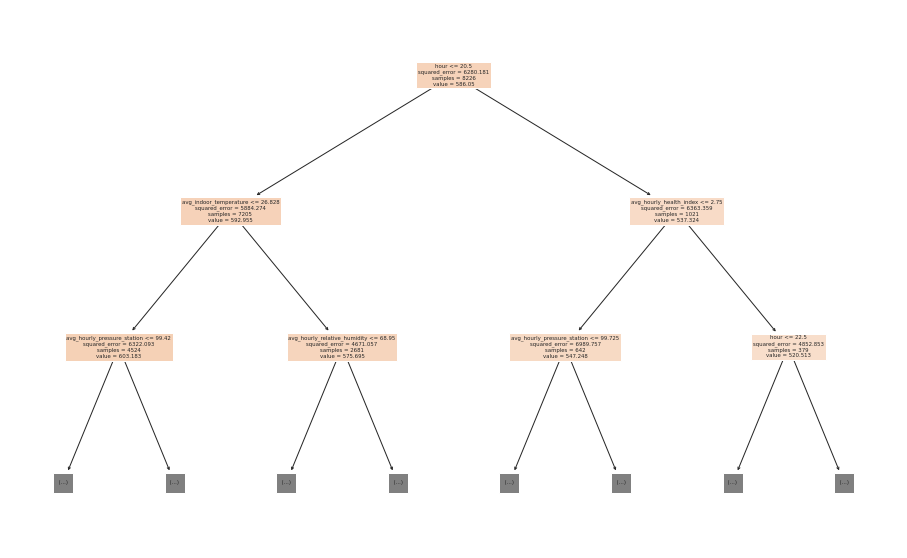

In [ ]:
# plotting first 2 levels of the best decision tree model

plt.figure(figsize=(16, 10))
tree.plot_tree(res_sq_error[best_d_sq_error]['model'], max_depth = 2, feature_names = X.columns, filled = True)

plt.show()

In [ ]:
# extracting feature importances of the tree
importances = res_sq_error[best_d_sq_error]['model'].feature_importances_
tree_model = res_sq_error[best_d_sq_error]['model']

tree_importances = pd.Series(importances, index=X.columns)
print(tree_importances)

hour                            0.258975
month                           0.059977
dayofweek                       0.044390
avg_indoor_temperature          0.190632
avg_hourly_temperature          0.109422
avg_hourly_relative_humidity    0.082390
avg_hourly_wind_speed           0.098550
avg_hourly_pressure_station     0.099635
avg_hourly_health_index         0.056029
dtype: float64


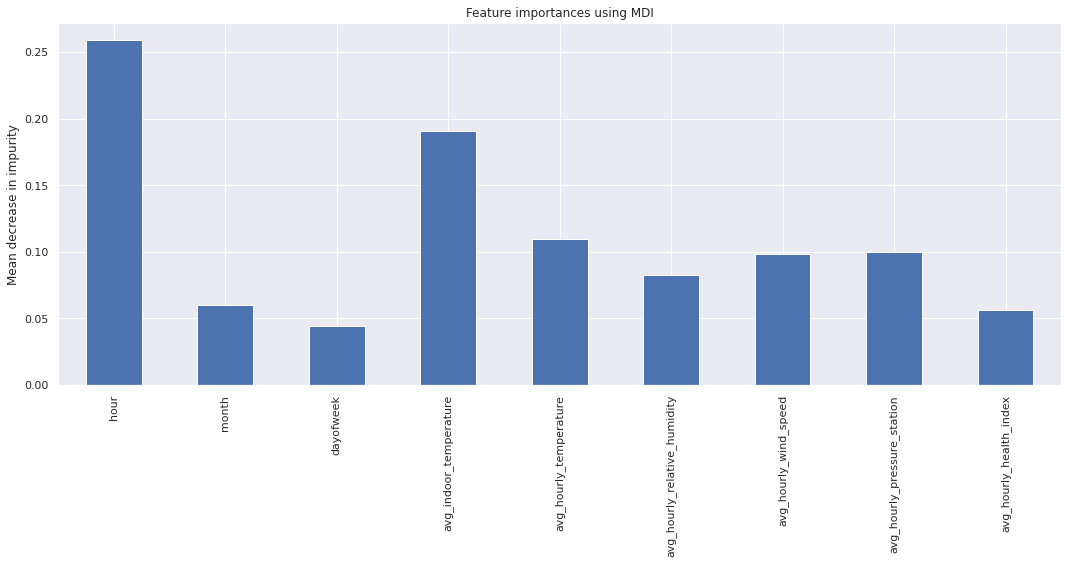

In [ ]:
# plotting feature importances 

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that the most important feature for the model was 'hour'. Then the algorithm used the weather features. Month and day of the week had the least impact. 

### 4.4. Random Forest



Next we'll try using Random Forest tree hoping for better predictable power in exchange for interpretability.

#### 4.4.1. Build the model

In [ ]:
# import Python packages

from sklearn.ensemble import RandomForestRegressor

We'll reuse the scoring function defined for the decision tree model.

In [ ]:
# define a function that selects the best random forest model among models with different depths
# selection is based on model score
def select_model_random_forest(depths,  criterion ):
    out = {}
    for d in depths:
        print('Evaluating on depth {}'.format(d))
        out[d] = {}
        regr = RandomForestRegressor(max_depth= d, random_state=0, criterion = criterion)
        regr.fit(X_train, y_train)  

        out[d]['test'] = get_acc(regr, X_test, y_test) # data['val'] is a tuple where 0 is array of data points, 1 is a vector of labels
        out[d]['train'] = get_acc(regr, X_train, y_train)
        out[d]['model'] = regr
    return out

#### 4.4.2. Make predictions and evaluate models

In [ ]:
depths = [2,5,8,9,10,15,20,30,50,70] # the depths we want to explore go in the depths list  

res_sq_error = select_model_random_forest(depths, "squared_error") # training models with different depths using squared error as criterion
# looping over the different models and scores to find the optimal model according to its test score
best_d_sq_error = None
best_acc_sq_error = 0

for d in res_sq_error:
    test_acc = res_sq_error[d]['test']
    print("Depth: {}   Train: {}    Test: {}".format(d, res_sq_error[d]['train'], test_acc))
    if test_acc  > best_acc_sq_error:
        best_d_sq_error = d
        best_acc_sq_error = test_acc

print('Best d (sq_error): ' + str(best_d_sq_error))
print('Best accuracy (sq_error): ' + str(best_acc_sq_error))

Evaluating on depth 2
Evaluating on depth 5
Evaluating on depth 8
Evaluating on depth 9
Evaluating on depth 10
Evaluating on depth 15
Evaluating on depth 20
Evaluating on depth 30
Evaluating on depth 50
Evaluating on depth 70
Depth: 2   Train: 0.08714073184870674    Test: 0.0829893345696825
Depth: 5   Train: 0.23383892805990758    Test: 0.19690102129499854
Depth: 8   Train: 0.48474041436239934    Test: 0.37672018972733257
Depth: 9   Train: 0.5730503964878881    Test: 0.43834595246678376
Depth: 10   Train: 0.6542167421426746    Test: 0.49743913982938304
Depth: 15   Train: 0.8971858901355239    Test: 0.6520403476338261
Depth: 20   Train: 0.9477376963122088    Test: 0.6808803830411541
Depth: 30   Train: 0.9535059785668947    Test: 0.6846544917436655
Depth: 50   Train: 0.9534790933359802    Test: 0.6829058598351887
Depth: 70   Train: 0.9534790933359802    Test: 0.6829058598351887
Best d (sq_error): 30
Best accuracy (sq_error): 0.6846544917436655


We see that random forest gives a better prediction power than a single decision tree model at around 68%.

#### 4.4.3. Visualize the model

We can't easily visualize the ensemble of trees in Random Forest, but we'll look at its feature importances.

In [ ]:
# extracting feature importances of the tree

importances = res_sq_error[best_d_sq_error]['model'].feature_importances_
forest_model = res_sq_error[best_d_sq_error]['model']

forest_importances = pd.Series(importances, index=X.columns)
print(forest_importances)

hour                            0.227742
month                           0.051872
dayofweek                       0.047925
avg_indoor_temperature          0.200221
avg_hourly_temperature          0.121358
avg_hourly_relative_humidity    0.098496
avg_hourly_wind_speed           0.093765
avg_hourly_pressure_station     0.096679
avg_hourly_health_index         0.061941
dtype: float64


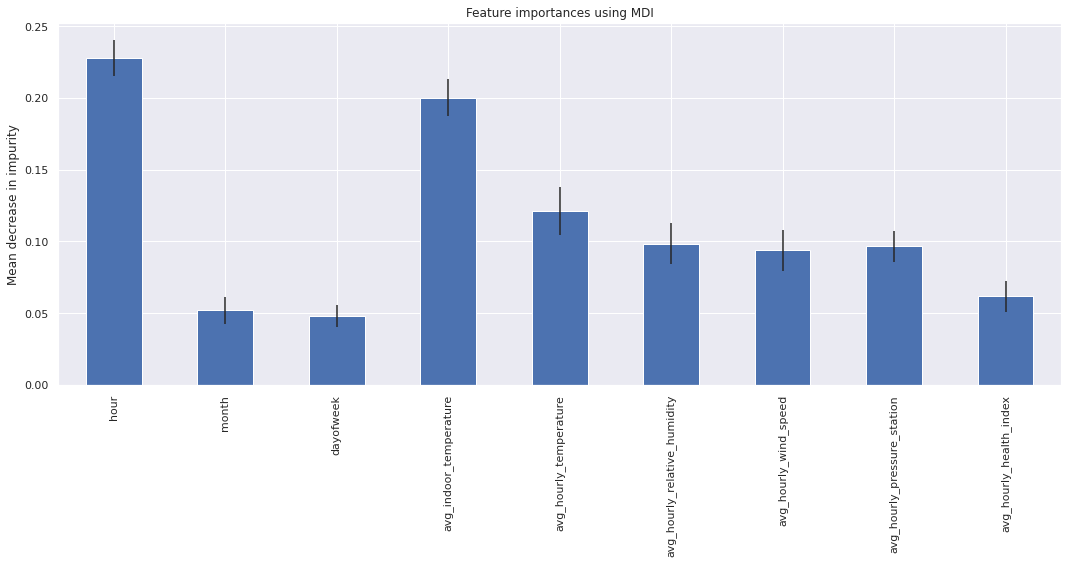

In [ ]:
# plotting feature importances

# calculating STD for error bars
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

# showing the plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that the order of importance of features is quite similar to the result for the single decision tree. 

### 4.5. Neural networks

We'll try building a simple neural network model, but it might not be the best approach for this task. With the tabular data that we have it might be hard to beat the results of random forest and this would need a lot of tweaking to come up with the optimal architecture for the network. 

#### 4.5.1. Build the model

In [ ]:
# Importing Python packages

import tensorflow as tf

In [ ]:
# defining the class for neural network model. it will allow to rerun different models
# by creating instances with different hyperparameters

class NN_Model:
  def __init__(self, I, H, learning_rate, act_function, display, N_epochs, batch_size):
    self.I = I #number of input neurons
    self.H = H
    self.learning_rate = learning_rate
    self.act_function = act_function
    self.display = display
    self.N_epochs = N_epochs
    self.batch_size = batch_size


# creating an instance of the class
# 9 input neurons because we have 9 features
# number of neurons in hidden layers, number of epochs and batch size
# were found out experimentally after running different versions
NN_Model_1 = NN_Model(9, 72, 0.01, 'relu', True, 10, 64) 


In [ ]:
# defining neural network architecture using TensorFlow
# last layer has simple linear activation function in one neuron as we try to predict a continous variable

def define_architecture(self):
  input_size = self.I
  output_size = 1
  hidden_size = self.H
  act_function = self.act_function
  learning_rate = self.learning_rate

  input_layer = tf.keras.Input(shape = (self.I))
  net = tf.keras.layers.Dense(self.H, activation='relu')(input_layer)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(36, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  out = tf.keras.layers.Dense(1, activation='linear')(net)

  self.model = tf.keras.models.Model(inputs=input_layer, outputs=out)

  msle = tf.keras.losses.MeanSquaredLogarithmicError()
  self.model.compile(
    loss=msle, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), 
    metrics=[msle]
    )
  
# defining architecture for our model instance
NN_Model.define_architecture = define_architecture
NN_Model_1.define_architecture()

Epoch 1/10
103/103 [==============================] - 1s 5ms/step - loss: 0.5958 - mean_squared_logarithmic_error: 0.5948 - val_loss: 0.0226 - val_mean_squared_logarithmic_error: 0.0227
Epoch 2/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0498 - mean_squared_logarithmic_error: 0.0498 - val_loss: 0.0210 - val_mean_squared_logarithmic_error: 0.0211
Epoch 3/10
103/103 [==============================] - 0s 4ms/step - loss: 0.0462 - mean_squared_logarithmic_error: 0.0461 - val_loss: 0.0196 - val_mean_squared_logarithmic_error: 0.0197
Epoch 4/10
103/103 [==============================] - 0s 4ms/step - loss: 0.0449 - mean_squared_logarithmic_error: 0.0449 - val_loss: 0.0188 - val_mean_squared_logarithmic_error: 0.0189
Epoch 5/10
103/103 [==============================] - 0s 4ms/step - loss: 0.0442 - mean_squared_logarithmic_error: 0.0442 - val_loss: 0.0188 - val_mean_squared_logarithmic_error: 0.0189
Epoch 6/10
103/103 [==============================] - 0s 3ms/step - lo

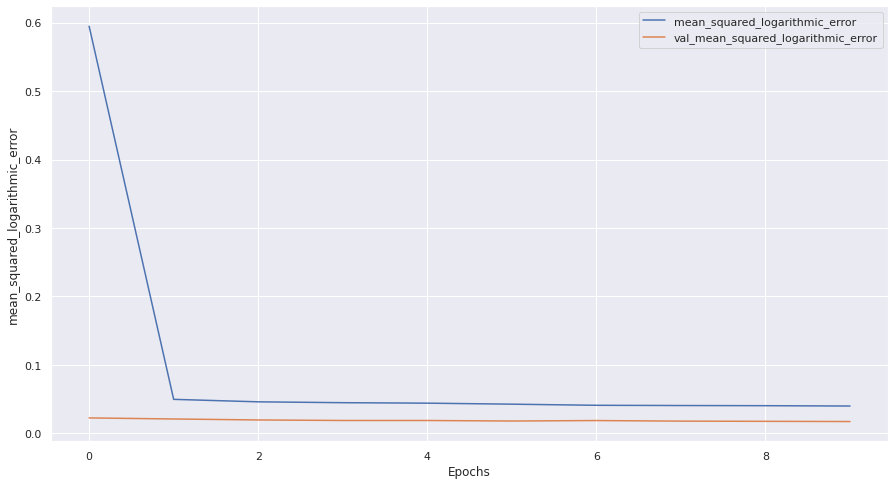

In [ ]:
# defining functions for training the model and displaying the results of the training

def train_model(self):
  self.history = self.model.fit(
    X_train, 
    y_train, 
    epochs=self.N_epochs, 
    batch_size=self.batch_size,
    validation_split=0.2
  )

def plot_history(self, key):
  plt.plot(self.history.history[key])
  plt.plot(self.history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

NN_Model.train_model = train_model
NN_Model.plot_history = plot_history

# training and displaying the results for our instance
NN_Model_1.train_model()
NN_Model_1.plot_history('mean_squared_logarithmic_error')

#### 4.5.2. Make predictions and evaluate models

In [ ]:
# defining a funtion to predict test results
def predict_model(self):
  self.y_predicted = self.model.predict(X_test)

# predicting test results using our model instance
NN_Model.predict_model = predict_model
NN_Model_1.predict_model()

In [ ]:
# printing the model score
print(metrics.r2_score(y_test, NN_Model_1.y_predicted))

0.04460526244941554


We see that the performance of the model is very poor compared to linear regression at around 4%. The model might not be very suitable for this task or more tuning of the architecture and hyperparameters is needed.

### 4.6. Nearest Neighbours

We'll also try using nearest neighbours. It might give good predictive power, but no interpretability. The model might be suitable for the task as there are a lot of datapoints in the training datasets and quite a few features (so the dimensionality is not that big).

In [ ]:
# importing Python packages 
from sklearn.neighbors import KNeighborsRegressor


#### 4.6.1. Build the model

In [ ]:
# defining a class for Nearest Neigbour models
# it will allow to run several models by creating instances with different parameters

class Neigh_Model:
  def __init__(self, K):
    self.K = K # number of nearest neighbours
    self.model = KNeighborsRegressor(n_neighbors=self.K)
  def train(self, X_train, y_train):
    self.model.fit(X_train, y_train)

# first we try to instantiate and train a model with 2 nearest neighbours as a parameter
neigh_model_1 = Neigh_Model(2)
neigh_model_1.train(X_train, y_train)


#### 4.6.2. Make predictions and evaluate models

In [ ]:
# defining functions for predicting test results and scoring the model
def neigh_predict(self, X_test):
  self.test_predicted = self.model.predict(X_test)

def neigh_score(self, y_test):
  self.score = metrics.r2_score(y_test, self.test_predicted)

Neigh_Model.neigh_predict = neigh_predict
Neigh_Model.neigh_score = neigh_score

# predicting test results and calculating score for our model instance
neigh_model_1.neigh_predict(X_test)
neigh_model_1.neigh_score(y_test)

print('test score: %f' % neigh_model_1.score)


test accuracy: 0.777035
4308    622.936364
6608    609.951010
1652    599.386937
888     571.143434
7730    539.061859
3894    630.320833
5211    574.701389
4897    563.747892
7103    631.354196
5167    574.191638
Name: avg_indoor_co2, dtype: float64
[573.82013889 606.94061027 687.92344697 576.33220668 559.87672624
 648.76818182 574.88263889 551.21092657 527.84914141 574.65812937]


The predictive power is quite high at around 77% which is the highest results among all explored models.

We'll also try running models with different numbers of nearest neighbours as a parameter.

In [ ]:
# defining a function to run the full cycle of trying out a model
def neigh_model_run(self, X_train, y_train, X_test, y_test):
  self.train(X_train, y_train)
  self.neigh_predict(X_test)
  self.neigh_score(y_test)

Neigh_Model.neigh_model_run = neigh_model_run



In [ ]:
# trying out models with the number of nearest neighbours from 1 to 9 and gathering their scores
test_scores = []
for k in range(1, 10):
    # Create K nearest neighbors classifier
    neigh_model_i = Neigh_Model(k)
    neigh_model_i.neigh_model_run(X_train, y_train, X_test, y_test)
    test_scores.append(neigh_model_i.score)

print(test_scores)

[0.6863121934997194, 0.7770348762039148, 0.7121322955370091, 0.6878419622338381, 0.645353873229097, 0.6095845341536134, 0.5756718653477438, 0.5368110147036231, 0.495732214424191]


Text(0, 0.5, 'Test set accuracy')

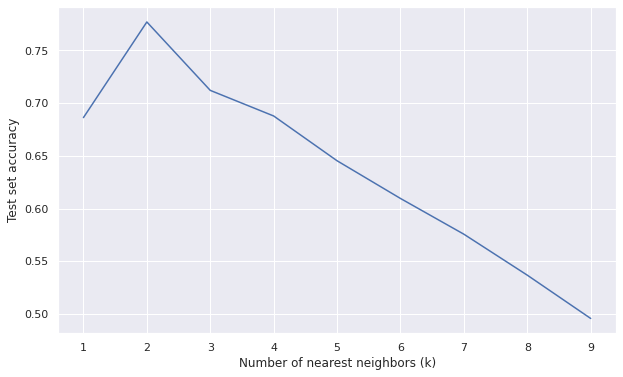

In [ ]:
# plotting the scores
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 10)), test_scores)
plt.xlabel('Number of nearest neighbors (k)')
plt.ylabel('Test set score')

We see that the initially chosen model with the number of nearest neighbours = 2 has the best score. 